# COMP 551 A3 CNN

## Image Classification

[CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html) is the dataset we are using for this assignment.

In [1]:
# Package install
import torch
import torchvision
import torchvision.transforms as transforms

F:\python3.68\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
F:\python3.68\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
F:\python3.68\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


## Load dataset

In [2]:
# Choose a batch size that feed into NN
batch_size = 256

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Show images

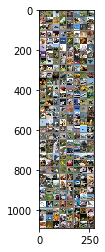

 bird  bird plane  bird


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## CNN model

* 4 Conv Layer
* 4 Batch Norm Layer
* 4 Max Pool Layer
* 4 Dropout Layer

In [3]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        
        # Conv layer keep the dimension of input image or 
        # prior layer data (extract features/generate feature maps or filters), 
        # while pooling layer decrease the data dimension exponentially (extract more important feature)
        
        # Conv2d - Convolutional layer: extract the features from the input images, ex. edge, pattern
        self.conv1 = nn.Conv2d(3, 6, 5) #in_channels = 3 RGB the input channels of prior layer or input image
                                        #out_channels = 16 the number of filters
                                        #kernel_size = 5 the convolutional kernel/filter feature sizes
                                        #Finally, we will input 3 channels RGB image and produce 16 different
                                        # filters of (5,5) kernal size
        
        # MaxPool2d - max pooling layer
        #Preserve the information but get rid of large portion of features, which are not important
        #Redure number of parameter of the finals in neural network
        #Avoid overfitting, disregarding the unnecessary information
        self.pool = nn.MaxPool2d(3, stride=2, padding=1)#kernel_size = 3 size of the max map
                                                        #stride = 2 how many stride shifts over the input matrix
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        # Use for dim transformation
        self.fc1 = nn.Linear(64*2*2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # Batchnorlization takes the output dim of prior layer as the input dim
        # It reduces overfitting because it has a slight regularization effects. 
        # Similar to Dropout, it adds some noise to each hidden layer’s activations
        # subtracting the batch mean and dividing by the batch standard deviation
        self.bn1 = nn.BatchNorm2d(6)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(64)
        # Dropout some number of layer outputs are randomly ignored or “dropped out.”
        self.dropout = nn.Dropout(0.3)


    def forward(self, x):
        # We first use the conv layer to extract information and then batch normalize
        # Then dropout some neurons with 0.3 probability in order to avoid overfitting
        # Then use relu activation to remove the negative value
        # Finally use the max pool technique to preserve information
        x = self.pool(F.relu(self.dropout(self.bn1(self.conv1(x)))))
        x = self.pool(F.relu(self.dropout(self.bn2(self.conv2(x)))))
        x = self.pool(F.relu(self.dropout(self.bn3(self.conv3(x)))))
        x = self.pool(F.relu(self.dropout(self.bn4(self.conv4(x)))))
        # Flatten the output of the prior layers in order to feed into linear functions
        x = x.view(-1, 64*2*2)
        # We use linear function to matrix operation for output the dim that we would like to
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Output our desired output dim - 10
        x = self.fc3(x)
        return x


net = Net()

In [4]:
import torch.optim as optim

# This is the cross entropy loss that we use to calculate the losses
criterion = nn.CrossEntropyLoss()
# Our optimizer is Stochastic gradient descent with predefined learning rate and momentum
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [5]:
# If GPU is available, deploy the model on it
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
from tqdm.notebook import tqdm
losses = []
acc = []
for epoch in tqdm(range(1000)):  # loop over the dataset multiple times
    correct = 0
    total = 0
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
#         print(inputs.shape)
        # forward + backward + optimize
        outputs = net(inputs)
#         print(outputs.shape, labels.shape)

        # Calculate the loss by the output of CNN and true labels
        loss = criterion(outputs, labels)
        # Backpropagation by the selection of optimizer: SGD
        loss.backward()
        # Update the gradient
        optimizer.step()
        
        # Get our predicted class
        _, predicted = torch.max(outputs.data, 1)
        # Accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        acc.append(correct/total)
        losses.append(loss)
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

### Train accuracy, loss plot

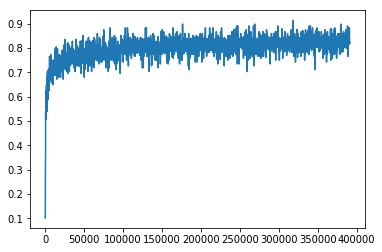

In [55]:
import matplotlib.pyplot as plt
plt.plot(acc)
# plt.plot(acc)
plt.show()

### Test image

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))

### Test accuracy

In [18]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

### Test accuracy by class

In [19]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))